In [ ]:
import numpy as onp
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

# plot functions
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

## Resources

**Theory**

* Kernel Methods in Machine Learning - Lecture 2: Regularized learning and kernels - [Slides](https://mycourses.aalto.fi/pluginfile.php/359553/mod_resource/content/1/CS-4830_Lecture2.pdf)
* Intro to ML Course - [Colab](https://www.papernot.fr/teaching/w20-ml)



## Data

True Weights:  [1.1355438]
(100, 1) (1000, 1) (100,)


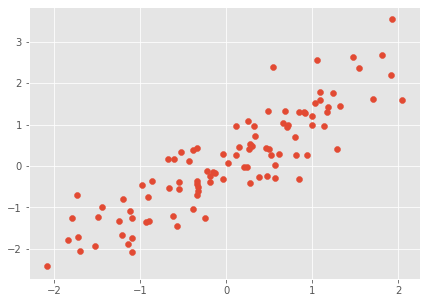

In [ ]:
#@title 1D Data

rng_key = random.PRNGKey(10)

n_samples, n_features = 100, 1

# generate X
X = random.normal(rng_key, shape=(n_samples, n_features))

# generate true w
true_w = random.normal(rng_key+1, shape=(n_features,))
print("True Weights: ", true_w)
# generate y = Xw + eps
eps = 0.5
y_true = jnp.dot(X, true_w) + eps * random.normal(rng_key+2, shape=(n_samples,))

X_plot = jnp.linspace(X.min(), X.max(), 1_000)[:, None]
print(X.shape, X_plot.shape, y_true.shape)

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, y_true)
plt.show()

## Theory

### Linear Regression
Regression is a form of curve fitting or function approximation. Regression models typically try to solve the following problem: We want to find some latent function $f(\cdot)$ s.t.

$$\hat{y}=f(\mathbf{x,w}) + \epsilon_y$$

where:
* $\mathbf{w}$ - weights, unknown parameters (`n_features`)
* $\mathbf{x}$ - are independent variables (`n_features`)
    * $\mathbf{X}$ - are independent variables stacked with samples/realizations (`n_samples, n_features`)
* $\mathbf{y}$ - are dependent variables (`n_targets`)
    * $\mathbf{Y}$ - are dependent variables stacked on top of each other (`n_samples, n_targets`)

We hope to approximate $m$- dimensional continuous functions via said $f(\cdot)$. So if $\mathbf{x} \in \mathbb{R}^{D}$, we want the function to map from to the target space $\mathbf{y} \in \mathbb{R}^{P}$. 


**How do we choose the weights?**

We can use **cross-validation** or we can **minimize a cost function** either by gradient descent or exact solutions.



In [ ]:
#@title Linear Model

# Linear Model
def linear_model(params, x):
    """"""
    return jnp.dot(params['w'], x) #+ params['b']


### Exact Solution

Firstly, we can solve this explicitly in closed-form:

$$\hat{\mathbf{w}} = (X^\top X)^{-1}X^\top\mathbf{y}$$

Fortunately, the jax library has a `np.linalg.pinv` implementation that allows us to calculate the gradients.

Weights:  [1.1138446]


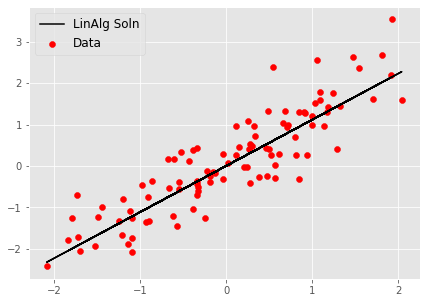

In [ ]:
# closed-form solution
w_linalg = jnp.dot(jnp.linalg.pinv(X), y_true)
print('Weights: ', w_linalg)

# add parameters to the weights
params = {'w': w_linalg}

# create linear model
model = linear_model

# vectorize the model, w.r.t. inputs
model = vmap(model, in_axes=(None, 0))

# evaluate linear model
y_linalg = model(params, X)

# Plot Results
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, y_true, label='Data', color='red')
ax.plot(X, y_linalg, label='LinAlg Soln', color='black')
ax.legend(fontsize=12)
plt.show()

In [ ]:
from dataclasses import dataclass 

@dataclass
class Params:
    # kernel params
    sigmas = [0.01, 0.1, 1.0]
    var = [10, 100, 1_000]
    # experimental params
    

In [ ]:
Params.sigmas, Params.var

([0.01, 0.1, 1.0], [10, 100, 1000])

```python
def f(w, b, x):
    return jnp.dot(x, w) + b

df_dw = jax.grad(f, argnums=(0))
df_db = jax.grad(f, argnums=(1))
df_dx = jax.grad(f, argnums=(2))
df_dw, df_db = jax.grad(f, argnums=(0, 1))
```

```python
def linear_model(params, x):
    return jnp.dot(x, params['w']) + params['b']
df_dw = jax.grad(f, argnums=(0))
```

1.1138446


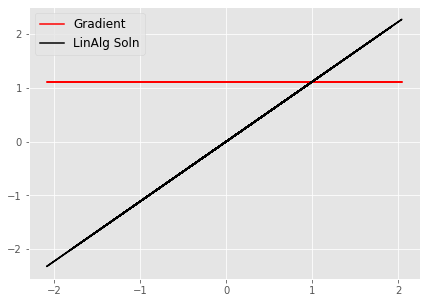

In [ ]:
# get gradient of model w.r.t. inputs (NOT params)
model_gradx = jax.grad(linear_model, argnums=(1))

# vectorize grad function
model_gradx = vmap(model_gradx, in_axes=(None, 0))

# get gradients w.r.t X
dydx = model_gradx(params, X)
print(jnp.mean(dydx))

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X, dydx, label='Gradient', color='red')
ax.plot(X, y_linalg, label='LinAlg Soln', color='black')
ax.legend(fontsize=12)
plt.show()

### Gradient Descent


We can also use gradient descent to tackle this problem. If we initialize $\mathbf{w}_0$ to be something random, then we can update:

$$\mathbf{w}_j = \mathbf{w}_{j-1} + \alpha \nabla \mathcal{L}(\mathbf{w}_{j-1})$$

where $\nabla$ is the gradient operator and $\alpha$ is the learning rate.

In [ ]:
# initialize params
def init_params(x):
    return {'w': jnp.zeros(len(x))}

params = init_params(X[0, :])
print(params)

{'w': DeviceArray([0.], dtype=float32)}


### Loss Function

Recall the model for simple:

$$y = X\mathbf{w}$$

We can define a loss function to describe the penalization:

$$\mathcal{L}(\mathbf{w}) 
= \left( f(\mathbf{w,x}) - y \right)^2$$

where $\mathbf{x,w} \in \mathbb{R}^D$ and $\mathbf{y} \in \mathbb{R}^P$

In [ ]:
from typing import Callable, Dict

# Linear Function
@jax.jit
def linear_model(params, x):
    """"""
    return jnp.dot(params['w'], x) #+ params['b']

# MSE Loss Function
@jax.jit
def squared_loss(
    params,
    x,
    y):
    """calculates the squared loss"""
    # output of model
    out = linear_model(params, x)

    # calculate the squared loss
    se = jnp.square(out - y)

    return  se

In [ ]:
# initialize loss function, squared loss
loss = squared_loss

# test loss function, single sample x
params = {'w': jnp.zeros(n_features)}
iloss = loss(params, X[0, :], y_true[0])

print(iloss, type(iloss))

0.00022611854 <class 'jax.interpreters.xla.DeviceArray'>


#### Vectorizing

In the above equation, we assumed that we only had one sample $\mathbf{x}$ of dimension D. What you'll typically see in your textbooks is the following: 


$$\mathcal{L}(\mathbf{w}) 
= \frac{1}{N}\sum_{i=1}^N\left( f(\mathbf{w,x_i}) - y_i \right)^2$$

where $N$ is the number of samples, $\mathbf{X} \in \mathbb{R}^{N \times D}$, $\mathbf{w} \in \mathbb{R}^D$ and $\mathbf{y} \in \mathbb{R}^P$

In JAX, we can vectorize this operation via the `vmap` function again so that we can deal with multiple samples.

In [ ]:
# initialize loss function, squared loss
loss = squared_loss

# vectorize loss function, w.r.t. inputs
loss = jax.jit(jax.vmap(loss, in_axes=(None, 0, 0), out_axes=0))

# test loss function, w.r.t. multiple inputs
nloss = loss(params, X, y_true)
print(nloss)

# mean squared loss
print(jnp.mean(nloss))

[8.0645442e-02 9.4554238e-02 8.3976537e-02 1.7630138e-02 5.0342840e-01
 5.0404724e-03 3.1685731e+00 6.6430980e-01 2.2337744e-02 2.3208328e-02
 1.5015393e+00 3.7379956e-01 6.4462519e-01 7.4515611e-01 3.8976738e-01
 2.2867156e-05 6.9685459e-02 2.6425380e-01 9.6766524e-02 1.4237852e-03
 9.8051831e-02 6.8827639e-03 8.4556288e-01 3.4373805e-02 6.5866634e-02
 3.1160021e-01 4.6697313e-01 8.4000355e-01 9.9518001e-02 1.0432125e-02
 6.5870367e-02 8.3173111e-02 1.3862267e-01 4.7982308e-01 1.3113645e-01
 6.6110724e-01 4.8840046e-02 1.4619049e-01 1.2185501e-01 1.6809237e-01
 4.4636085e-04 9.4798086e-03 2.6795484e-02 1.6848260e-01 2.9315330e-02
 5.3964442e-01 3.9085913e-02 3.4926262e-01 1.0814760e-01 2.9149374e-01
 9.6950477e-01 9.5541972e-01 5.9873456e-01 1.0549072e+00 1.5576355e+00
 2.5051956e-03 1.2020152e-01 1.0441923e-02 3.7289292e-03 3.7731159e-02
 3.7940878e-01 4.3410741e-02 3.7870684e-01 4.2859063e-01 8.0190808e-02
 6.1363888e-01 6.0083166e-02 6.9471574e-01 1.1167380e-01 3.2192516e-01
 9.779

### Loss Gradient

In [ ]:
# create grad function from loss
grad_loss = jax.jit(jax.grad(squared_loss, argnums=(0)))

# vectorize grad_loss
grad_loss = jax.jit(jax.vmap(grad_loss, in_axes=(None, 0, 0)))

# gradients
iloss = grad_loss(params, X, y_true)

print(jnp.mean(iloss['w']))

-5.2928925e-07


### Training

In [ ]:
iloss

DeviceArray(0.32943642, dtype=float32)

In [ ]:
# do gradient descent
params = init_params(X[0, :])
print(params['w'])
losses = []
epsilon = 0.1
iterations = 100

for _ in range(iterations):
    
    # calculate the loss
    iloss = loss(params, X, y_true)
    iloss = jnp.mean(iloss)
    
    losses.append(iloss)

    # calculate the gradients of loss
    grad_losses = grad_loss(params, X, y_true)

    # average gradients over batch, update params
    params['w'] = params['w'] - epsilon * jnp.mean(grad_losses['w'], axis=0)
    
    # print(iloss, jnp.mean(grad_losses['w'], axis=0))
print(params)

[0.]
{'w': DeviceArray([1.1138444], dtype=float32)}


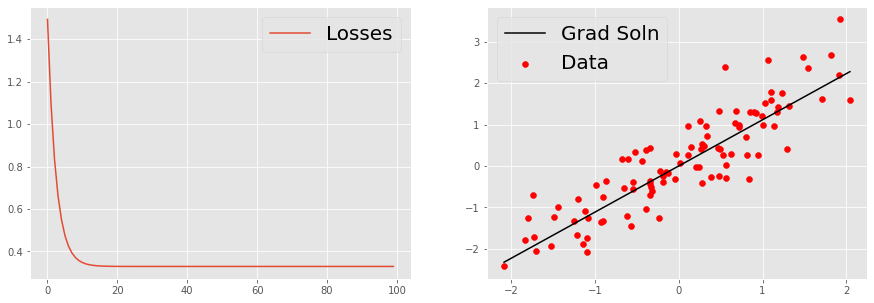

In [ ]:


fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

# plot the losses
ax[0].plot(losses, label='Losses')
ax[0].legend(fontsize=20)

# plot the resulting line
y_pred = vmap(linear_model, in_axes=(None, 0))(params, X_plot)

ax[1].scatter(X, y_true, label='Data', color='red')
ax[1].plot(X_plot, y_pred, label='Grad Soln', color='black')
ax[1].legend(fontsize=20)

plt.show()



### Penalized Linear Regression: Ridge Regression

For kernel methods, we add a penalty to the loss function.

$$
\mathcal{L}(\mathbf{w, \lambda}) 
= \underset{\mathbf{w}}{\text{min}}
\left\{ 
    ||\mathbf{Y}-\mathbf{Xw} ||^2 + \lambda ||\mathbf{w}||^2 
\right\}
$$


In [ ]:
# initialize params
def init_params(x):
    return {'w': jnp.ones(len(x)), 'lambda': 0.01 * jnp.ones((1,))}

params = init_params(X[0, :])
print(params)

{'w': DeviceArray([1.], dtype=float32), 'lambda': DeviceArray([0.01], dtype=float32)}


In [ ]:
from typing import Callable, Dict

# Linear Function
@jax.jit
def linear_model(params, x):
    """"""
    return jnp.dot(params['w'], x) #+ params['b']

# MSE Loss Function
@jax.jit
def l2_squared_loss(
    params,
    x,
    y,
    l2=0.01):
    """calculates the squared loss"""
    # output of model
    out = linear_model(params, x)

    # calculate the squared loss
    se = jnp.power(out - y, 2)

    # add l2 regularization
    # print(jnp.square(jnp.linalg.norm(params['w'], 2)))
    reg = l2 * jnp.square(jnp.linalg.norm(params['w'], 2))
    # print(reg)
    return se + reg

In [ ]:
def make_loss_n_grad(loss_func, params, X, y_true, test=False, jitted=True):

    # =========================
    # Loss Function
    # =========================

    # vectorize loss function, w.r.t. inputs
    if jitted == True:
        loss = jax.jit(jax.vmap(loss_func, in_axes=(None, 0, 0), out_axes=0))
    else:
        loss = jax.vmap(loss_func, in_axes=(None, 0, 0), out_axes=0)

    if test == True:
        # test loss function, w.r.t. multiple inputs
        nloss = loss(params, X, y_true)

        # mean squared loss
        print(jnp.mean(nloss))
    
    # =========================
    # Grad Loss Function
    # =========================
    
    # grad_loss = jax.grad(l2_squared_loss, argnums=(0))
    if jitted:
        # create grad function from loss
        grad_loss = jax.jit(jax.grad(loss_func, argnums=(0)))

        # vectorize grad_loss
        grad_loss = jax.jit(jax.vmap(grad_loss, in_axes=(None, 0, 0)))
    else:
        # create grad function from loss
        grad_loss = jax.grad(loss_func, argnums=(0))

        # vectorize grad_loss
        grad_loss = jax.vmap(grad_loss, in_axes=(None, 0, 0))
    

    if test == True:
        # gradients
        iloss = grad_loss(params, X, y_true)

        print(jnp.mean(iloss['w']))
    return loss, grad_loss

In [ ]:
# init params
params = init_params(X[0, :])
print("Params:", params)
# create loss functions
loss, grad_loss = make_loss_n_grad(l2_squared_loss, params, X, y_true, test=True)

Params: {'w': DeviceArray([1.], dtype=float32), 'lambda': DeviceArray([0.01], dtype=float32)}
0.35159916
-0.1936729


In [ ]:
losses = []
alpha = 0.1
iterations = 100

for _ in range(iterations):
    
    # calculate the loss
    iloss = loss(params, X, y_true)
    iloss = jnp.mean(iloss)
    
    losses.append(iloss)

    # calculate the gradients of loss
    grad_losses = grad_loss(params, X, y_true)

    # average gradients over batch, update params
    params['w'] = params['w'] - alpha * jnp.mean(grad_losses['w'], axis=0)
    # print(iloss, jnp.mean(grad_losses['w'], axis=0))
print(params)

{'w': DeviceArray([1.1021005], dtype=float32), 'lambda': DeviceArray([0.01], dtype=float32)}


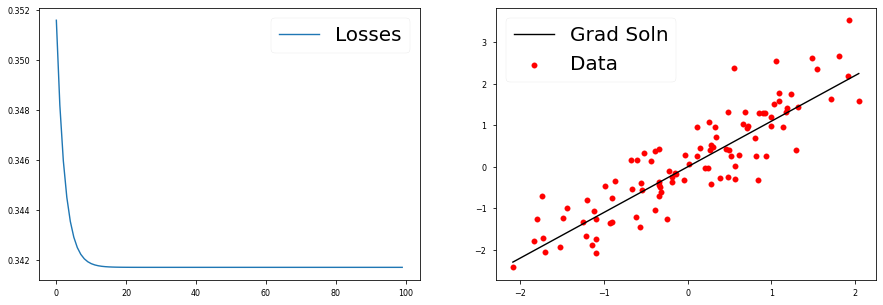

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

# plot the losses
ax[0].plot(losses, label='Losses')
ax[0].legend(fontsize=20)

# plot the resulting line
y_pred = vmap(linear_model, in_axes=(None, 0))(params, X_plot)

ax[1].scatter(X, y_true, label='Data', color='red')
ax[1].plot(X_plot, y_pred, label='Grad Soln', color='black')
ax[1].legend(fontsize=20)

plt.show()